# VRP Demo with SCIP
This file is intended to build the model for the CVRP using SCIP

In [1]:
from pyscipopt import Model, Pricer, SCIP_RESULT, SCIP_STAGE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np

from cffi import FFI
ffi = FFI()
labelling_lib = ffi.dlopen("Labelling/labelling_lib.so")

funDefs = "void initGraph(unsigned num_nodes, unsigned* node_data, double* edge_data, const double capacity); void labelling(double const * dual,const bool farkas, unsigned* result);"
ffi.cdef(funDefs, override=True)

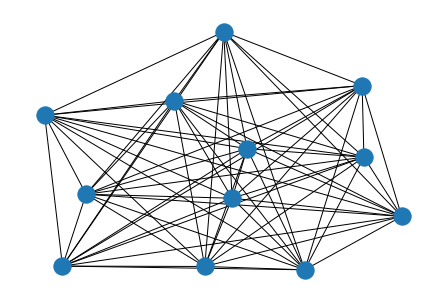

In [2]:
# Create Graph
G = nx.complete_graph(12)
for (u, v) in G.edges():
    G.edges[u,v]['weight'] = random.randint(1,10)
    
for node in G.nodes():
    G.nodes()[node]['demand'] = random.randint(1,10)

nx.draw(G)

In [3]:
# Create Simple Graph for correctnes
G = nx.complete_graph(4)
G.remove_edge(0,3)
for (u, v) in G.edges():
    G.edges[u,v]['weight'] = 1
G.edges[1,2]['weight'] = 1

for node in G.nodes():
    G.nodes()[node]['demand'] = 1

# nx.draw(G,with_labels=True)

In [3]:
class VRP(Model):
    def __init__(self,graph):
        super().__init__()
        
        self.original_graph = graph
        self.graph = graph.copy()
        self.vars = {}
        self.cons = []

In [4]:
class VRPPricer(Pricer): 
    def pricerinit(self):
        self.data['cons'] = [self.model.getTransformedCons(con) for con in self.model.cons]
        self.data['vars'] = {path:self.model.getTransformedVar(var) for (path,var) in self.model.vars.items()}
        
        print(f" There are {len(self.model.getConss())} constraints in the model and {len(self.data['cons'])} of them are known to the pricer.")
        
        node_data = list(nx.get_node_attributes(self.model.graph,"demand").values())
        if not np.all(np.array(node_data)):
           print("PRICER_PY: The demands of all nodes must be > 0.")
        print(node_data)
        nodes_arr = ffi.cast("unsigned*", np.array(node_data).astype(np.uintc).ctypes.data)

        edges = nx.adjacency_matrix(self.model.graph,dtype=np.double).toarray()
        edges_arr = ffi.cast("double*", edges.ctypes.data)
        
        num_nodes = ffi.cast("unsigned",self.model.graph.number_of_nodes())
        
        capacity_ptr = ffi.cast("double",self.data['capacity'])
        labelling_lib.initGraph(num_nodes,nodes_arr,edges_arr, capacity_ptr)
    
    def pricerfarkas(self):
#         print("Farkas Pricing has been called.")
        dual = [self.model.getDualfarkasLinear(con) for con in self.data['cons']]
        print(f"Farkas Values are {dual}")
        return self.labelling(dual, farkas=True)

    def pricerredcost(self):
        pi = [self.model.getDualsolLinear(con) for con in self.data['cons']]
        print(f"Dual variables are {pi}")
        return self.labelling(pi)
    
    def labelling(self, dual,farkas=False):
        pointer_dual = ffi.cast("double*", np.array(dual,dtype=np.double).ctypes.data)
        
        # TODO: Possible improvement: result can be reused every time
        result = np.zeros(self.data['capacity'] + 10,dtype=np.uintc)
        # Should be capacity + 2, but I gave it a little more room
        result_arr = ffi.cast("unsigned*",result.ctypes.data)
        
        labelling_lib.labelling(pointer_dual, False,result_arr)
        
        if(result[0] == 1):
            print("There are no paths with negative reduced costs")
            # There are no paths with negative reduced costs
            return {'result':SCIP_RESULT.SUCCESS}
        
        print(result)
        result_indices = np.insert(np.nonzero(result),0,0)
#         print(np.insert(np.nonzero(result),0,0))
        path = tuple(result[result_indices])
        print(f"Labelling found path {path} with negative reduced cost")
        if path in self.data['vars'].keys():
            cost = self.model.getVarRedcost(self.data['vars'][path])
            print(f"Path already in variables with reduced cost {cost} with farkas {farkas}.")
            return {'result':SCIP_RESULT.SUCCESS}
        
        var = self.model.addVar(vtype="I",obj=nx.path_weight(self.model.graph,path,"weight"),pricedVar=True)
        weight = nx.path_weight(self.model.graph,path,"weight")
        print(f"Added {path} with path weight {weight}")
        counts = np.unique(path[1:-1], return_counts=True)
        for i, node in enumerate(counts[0]):
            print(f"There are {counts[1][i]} occurences of node {node}")
            self.model.addConsCoeff(self.data['cons'][node-1], var ,counts[1][i])

        self.model.addConsCoeff(self.data['cons'][-1], var, 1)
        self.data['vars'][tuple(path)] = var
        
        return {'result':SCIP_RESULT.SUCCESS}

In [5]:
model = VRP(G)
num_vehicles = 12

# Create pricer
pricer = VRPPricer()
pricer.data = {}
pricer.data["capacity"] = 30
pricer.data["num_vehicles"] = num_vehicles
model.includePricer(pricer, "pricer","does pricing")

# Create a valid set of variables and the constraints to it
for i in range(1,G.number_of_nodes()-1):
    path = (0,i,G.number_of_nodes()-1)
    cost = nx.path_weight(G,path,"weight")
    var = model.addVar(vtype="I",obj=cost)
    model.vars[path] = var
    cons = model.addCons(var == 1, name=str(node),modifiable=True)
    model.cons.append(cons)
    
# Add the convexity constraint, which limits the number of available vehicles
convexity_constraint = model.addCons(sum(model.vars.values()) <= num_vehicles, modifiable=True)
model.cons.append(convexity_constraint)

model.hideOutput()
model.optimize()
model.hideOutput(quiet=False)
model.printBestSol()
print(pricer.data['vars'])

 There are 11 constraints in the model and 11 of them are known to the pricer.
[8, 10, 8, 7, 6, 5, 5, 2, 5, 5, 6, 4]
Dual variables are [14.0, 10.0, 9.0, 20.0, 12.0, 9.0, 17.0, 13.0, 11.0, 12.0, -0.0]Graph data successfully copied to C.

PRICER_C: Capacity is 30
PRICER_C: Found path with load 18
Path is currently at node 2 with load 8
PRICER_C: Found path with load 17
Path is currently at node 3 with load 7
PRICER_C: Found path with load 16
Path is currently at node 4 with load 6
PRICER_C: Found path with load 15
Path is currently at node 5 with load 5
PRICER_C: Found path with load 15
Path is currently at node 6 with load 5
PRICER_C: Found path with load 12
Path is currently at node 7 with load 2
PRICER_C: Found path with load 15
Path is currently at node 8 with load 5
PRICER_C: Found path with load 15
Path is currently at node 9 with load 5
PRICER_C: Found path with load 16
Path is currently at node 10 with load 6
PRICER_C: Found path with load 18
Path is currently at node 1 with loa

 is currently at node 10 with load 6
PRICER_C: Found path with load 30
Path is currently at node 7 with load 2
Path is currently at node 1 with load 10
Path is currently at node 2 with load 8
PRICER_C: Found path with load 29
Path is currently at node 7 with load 2
Path is currently at node 1 with load 10
Path is currently at node 3 with load 7
PRICER_C: Found path with load 27
Path is currently at node 7 with load 2
Path is currently at node 2 with load 8
Path is currently at node 3 with load 7
PRICER_C: Found path with load 28
Path is currently at node 5 with load 5
Path is currently at node 4 with load 6
Path is currently at node 3 with load 7
PRICER_C: Found path with load 28
Path is currently at node 6 with load 5
Path is currently at node 4 with load 6
Path is currently at node 3 with load 7
PRICER_C: Found path with load 30
Path is currently at node 3 with load 7
Path is currently at node 10 with load 6
Path is currently at node 3 with load 7
PRICER_C: Found path with load 29
Pa

Path is currently at node 3 with load 7
PRICER_C: Found path with load 26
Path is currently at node 6 with load 5
Path is currently at node 10 with load 6
Path is currently at node 3 with load 7
PRICER_C: Found path with load 26
Path is currently at node 8 with load 5
Path is currently at node 10 with load 6
Path is currently at node 3 with load 7
PRICER_C: Found path with load 25
Path is currently at node 4 with load 6
Path is currently at node 9 with load 5
Path is currently at node 4 with load 6
PRICER_C: Found path with load 28
Path is currently at node 2 with load 8
Path is currently at node 10 with load 6
Path is currently at node 4 with load 6
PRICER_C: Found path with load 27
Path is currently at node 3 with load 7
Path is currently at node 10 with load 6
Path is currently at node 4 with load 6
PRICER_C: Found path with load 26
Path is currently at node 4 with load 6
Path is currently at node 10 with load 6
Path is currently at node 4 with load 6
PRICER_C: Found path with load 

Path is currently at node 5 with load 5
PRICER_C: Found path with load 30
Path is currently at node 3 with load 7
Path is currently at node 7 with load 2
Path is currently at node 8 with load 5
Path is currently at node 7 with load 2
Path is currently at node 8 with load 5
Path is currently at node 7 with load 2
Path is currently at node 5 with load 5
PRICER_C: Found path with load 29
Path is currently at node 4 with load 6
Path is currently at node 7 with load 2
Path is currently at node 8 with load 5
Path is currently at node 7 with load 2
Path is currently at node 8 with load 5
Path is currently at node 7 with load 2
Path is currently at node 5 with load 5
PRICER_C: Found path with load 28
Path is currently at node 5 with load 5
Path is currently at node 7 with load 2
Path is currently at node 8 with load 5
Path is currently at node 7 with load 2
Path is currently at node 8 with load 5
Path is currently at node 7 with load 2
Path is currently at node 5 with load 5
PRICER_C: Found pa

There are no paths with negative reduced costs
Dual variables are [5.427631578947369, -4.513157894736843, -0.35526315789473717, 4.4407894736842115, 0.5394736842105257, 2.4407894736842115, 4.552631578947368, 5.835526315789474, 3.697368421052632, 5.039473684210526, -0.0]
h with load 24
Path is currently at node 9 with load 5
Path is currently at node 10 with load 6
Path is currently at node 3 with load 7
PRICER_C: Found path with load 23
Path is currently at node 9 with load 5
Path is currently at node 10 with load 6
Path is currently at node 4 with load 6
PRICER_C: Found path with load 22
Path is currently at node 9 with load 5
Path is currently at node 10 with load 6
Path is currently at node 6 with load 5
PRICER_C: Found path with load 30
Path is currently at node 6 with load 5
Path is currently at node 10 with load 6
Path is currently at node 6 with load 5
Path is currently at node 10 with load 6
PRICER_C: Found path with load 30
Path is currently at node 9 with load 5
Path is curren

Farkas Values are [0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0]urrently at node 6 with load 5
Path is currently at node 4 with load 6
PRICER_C: Found path with load 27
Path is currently at node 4 with load 6
Path is currently at node 6 with load 5
Path is currently at node 4 with load 6
PRICER_C: Found path with load 26
Path is currently at node 5 with load 5
Path is currently at node 6 with load 5
Path is currently at node 4 with load 6
PRICER_C: Found path with load 27
Path is currently at node 10 with load 6
Path is currently at node 6 with load 5
Path is currently at node 4 with load 6
PRICER_C: Found path with load 30
Path is currently at node 5 with load 5
Path is currently at node 1 with load 10
Path is currently at node 6 with load 5
PRICER_C: Found path with load 30
Path is currently at node 6 with load 5
Path is currently at node 1 with load 10
Path is currently at node 6 with load 5
PRICER_C: Found path with load 30
Path is currently at node 8 with load 5
Path is 

d 5
Path is currently at node 7 with load 2
Path is currently at node 9 with load 5
Path is currently at node 7 with load 2
PRICER_C: Found path with load 28
Path is currently at node 7 with load 2
Path is currently at node 9 with load 5
Path is currently at node 7 with load 2
Path is currently at node 9 with load 5
Path is currently at node 7 with load 2
Path is currently at node 9 with load 5
Path is currently at node 7 with load 2
PRICER_C: Found path with load 30
Path is currently at node 3 with load 7
Path is currently at node 7 with load 2
Path is currently at node 9 with load 5
Path is currently at node 7 with load 2
Path is currently at node 9 with load 5
Path is currently at node 7 with load 2
Path is currently at node 9 with load 5
PRICER_C: Found path with load 29
Path is currently at node 4 with load 6
Path is currently at node 7 with load 2
Path is currently at node 9 with load 5
Path is currently at node 7 with load 2
Path is currently at node 9 with load 5
Path is curren

PRICER_C: Found path with load 28
Path is currently at node 8 with load 5
Path is currently at node 1 with load 10
Path is currently at node 5 with load 5
PRICER_C: Found path with load 28
Path is currently at node 9 with load 5
Path is currently at node 1 with load 10
Path is currently at node 5 with load 5
PRICER_C: Found path with load 24
Path is currently at node 5 with load 5
Path is currently at node 4 with load 6
Path is currently at node 5 with load 5
PRICER_C: Found path with load 24
Path is currently at node 6 with load 5
Path is currently at node 4 with load 6
Path is currently at node 5 with load 5
PRICER_C: Found path with load 27
Path is currently at node 3 with load 7
Path is currently at node 1 with load 10
Path is currently at node 7 with load 2
PRICER_C: Found path with load 25
Path is currently at node 8 with load 5
Path is currently at node 1 with load 10
Path is currently at node 7 with load 2
PRICER_C: Found path with load 25
Path is currently at node 9 with load 

## Old Labelling

In [ ]:

    def simple_labeling(self,dual,farkas=False):
        for path in nx.all_simple_paths(self.model.graph,0,list(G.nodes())[-1]):
            if tuple(path) not in self.data['vars'].keys():
                if farkas:
                    weight = 0
                else:
                    weight = nx.path_weight(self.model.graph,path,"weight")
                load = 0
                
                for node in path[1:-1]:
                    weight -= dual[node-1]
                    load += self.model.graph.nodes()[node]['demand']
                if weight < 0 and load <= self.data['capacity']:
                    var = self.model.addVar(vtype="B",obj=nx.path_weight(self.model.graph,path,"weight"),pricedVar=True)
                    for node in path[1:-1]:
                        self.model.addConsCoeff(self.data['cons'][node-1], var ,1)
                    
                    self.model.addConsCoeff(self.data['cons'][-1], var, 1)
                    self.data['vars'][tuple(path)] = var
#                     print(f"Found path {path} with negative reduced cost")
                    return {'result':SCIP_RESULT.SUCCESS}
        return {'result':SCIP_RESULT.SUCCESS}